# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

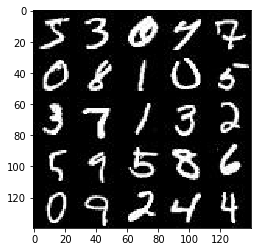

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

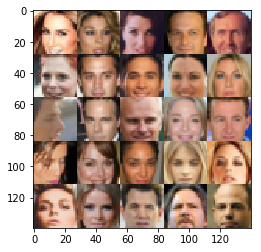

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='images')
    z = tf.placeholder(tf.float32,(None, z_dim), name='z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\bryan\\AppData\\Local\\conda\\conda\\envs\\tensorflow\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\bryan\\AppData\\Local\\conda\\conda\\envs\\tensorflow\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\bryan\\AppData\\Local\\conda\\conda\\envs\\tensorflow\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\bryan\\AppData\\Local\\conda\\conda\\envs\\tensorflow\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\bryan\\AppData\\Local\\conda\\conda\\envs\\tensorflow\\

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:

def discriminator(images, reuse=False, alpha = 0.0):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        #input 28x28x3
        layer_1 = tf.layers.conv2d(images,64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        
        #input 14x14x64
        layer_2 = tf.layers.conv2d(layer_1,128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        
        #input 7x7x128
        layer_3 = tf.layers.conv2d(layer_2,256, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        #input 4x4x256
        
        layer_4 = tf.layers.conv2d(layer_3,512, 2, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        layer_5 = tf.reshape(layer_4,(-1, 2*2*512))
        
        
        #input 4096
        logits =  tf.layers.dense(layer_5, 1)
        out = tf.sigmoid(logits)
        
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:

import problem_unittests as tests
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    with tf.variable_scope('generator',reuse=not is_train):
        size =4*4*512
        layer_1 = tf.layers.dense(z, size, activation=None)
        layer_1 = tf.reshape(layer_1, (-1, 4, 4, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        
        #input  4x4x512
        layer_2 = tf.layers.conv2d_transpose(layer_1,128, 4, strides=1, padding='valid')
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        
        #input 8x8x128
        layer_3 = tf.layers.conv2d_transpose(layer_2,64, 5, strides=2, padding='same')
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        
        layer_4 = tf.layers.conv2d_transpose(layer_3, 32, 5, strides=2, padding='same')
        layer_4 = tf.layers.batch_normalization(layer_4, training=is_train)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        
        #input 16x16x64
        logits= tf.layers.conv2d_transpose(layer_4, out_channel_dim,3, strides=1, padding='same')
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    images, z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    print(data_shape)
    d_loss, g_loss = model_loss(images, z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for i, batch_images in enumerate(get_batches(batch_size)):
                
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # TODO: Train Model
                _, d_loss_value = sess.run([d_train_opt, d_loss], feed_dict={images: batch_images, z: batch_z, lr: learning_rate })
                _, g_loss_value = sess.run([g_train_opt, g_loss],feed_dict={z: batch_z, images: batch_images, lr: learning_rate})
                
                if i % 100 == 0:
                    print("Discriminator Loss: {} \nGenerator Loss: {}".format(d_loss_value, g_loss_value))
                    show_generator_output(sess, 9, z, data_shape[3], data_image_mode)
            
            print("After Epoch {}".format(epoch_i))
            print("Discriminator Loss: {} \nGenerator Loss: {}".format(d_loss_value, g_loss_value))
            show_generator_output(sess, 25, z, data_shape[3], data_image_mode)
    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Discriminator Loss: 1.1689952611923218 
Generator Loss: 11.99380111694336


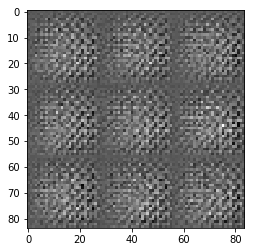

Discriminator Loss: 0.3534063696861267 
Generator Loss: 3.440901756286621


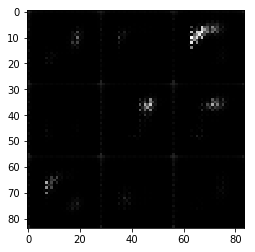

Discriminator Loss: 0.388164222240448 
Generator Loss: 3.9094183444976807


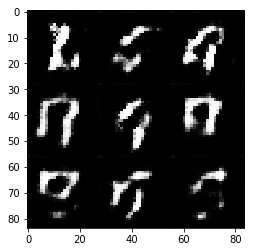

Discriminator Loss: 0.9400421977043152 
Generator Loss: 1.1360695362091064


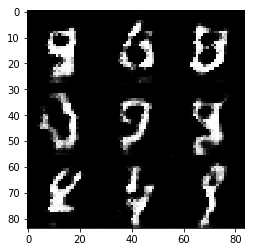

Discriminator Loss: 1.6076875925064087 
Generator Loss: 3.6205554008483887


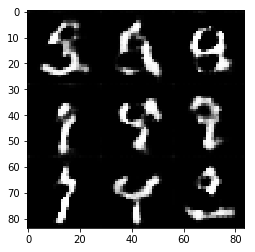

Discriminator Loss: 1.0614948272705078 
Generator Loss: 1.45589280128479


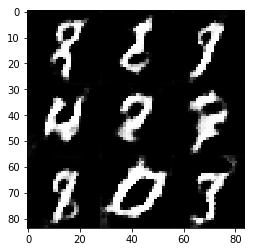

Discriminator Loss: 0.9118109941482544 
Generator Loss: 2.6802549362182617


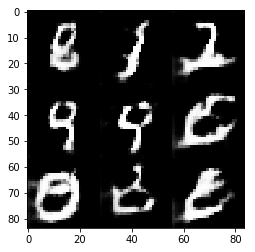

Discriminator Loss: 0.8848307132720947 
Generator Loss: 2.4584357738494873


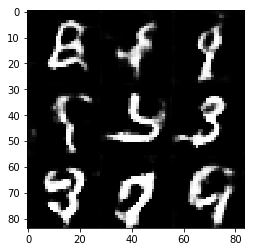

Discriminator Loss: 1.3762799501419067 
Generator Loss: 1.4716222286224365


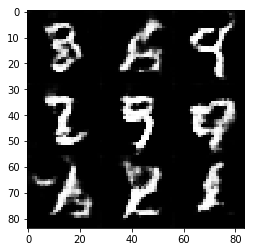

Discriminator Loss: 0.6310523748397827 
Generator Loss: 1.4269214868545532


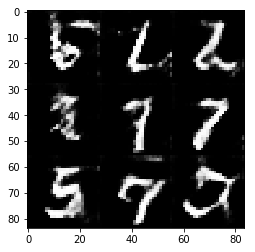

Discriminator Loss: 1.0753543376922607 
Generator Loss: 1.9388198852539062


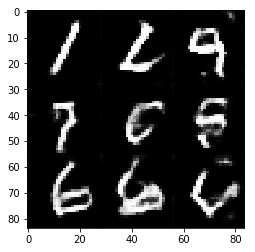

Discriminator Loss: 1.8468475341796875 
Generator Loss: 3.8909921646118164


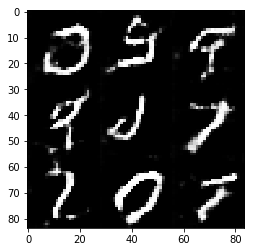

Discriminator Loss: 0.8050564527511597 
Generator Loss: 1.4679293632507324


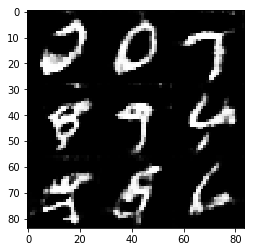

Discriminator Loss: 0.5878528356552124 
Generator Loss: 1.676574468612671


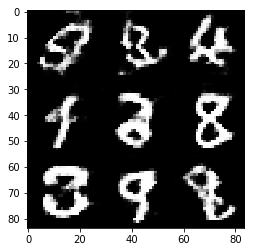

Discriminator Loss: 1.4278913736343384 
Generator Loss: 4.497448921203613


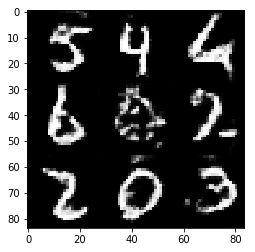

Discriminator Loss: 0.698324978351593 
Generator Loss: 1.950890302658081


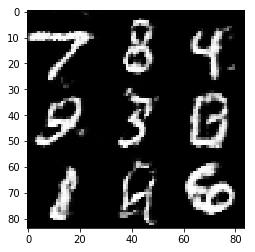

Discriminator Loss: 0.8547897338867188 
Generator Loss: 3.461550235748291


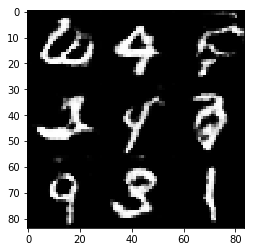

Discriminator Loss: 0.6551666855812073 
Generator Loss: 2.7766427993774414


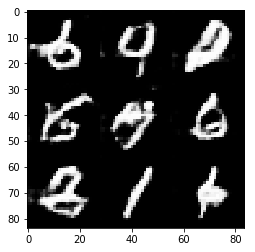

Discriminator Loss: 0.9449495077133179 
Generator Loss: 1.5219180583953857


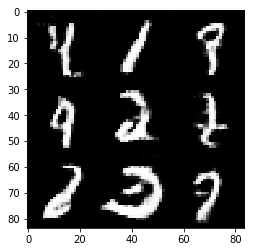

After Epoch 0
Discriminator Loss: 0.8119676113128662 
Generator Loss: 1.2869198322296143


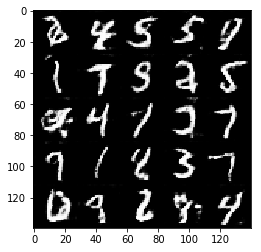

Discriminator Loss: 0.959291934967041 
Generator Loss: 0.85013747215271


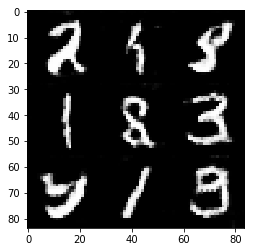

Discriminator Loss: 0.7879571318626404 
Generator Loss: 3.871912956237793


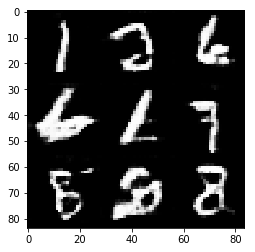

Discriminator Loss: 0.7300474643707275 
Generator Loss: 2.3289976119995117


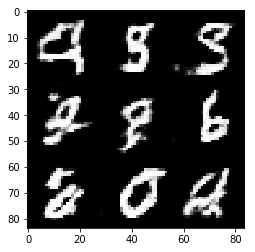

Discriminator Loss: 0.7143023014068604 
Generator Loss: 2.7021491527557373


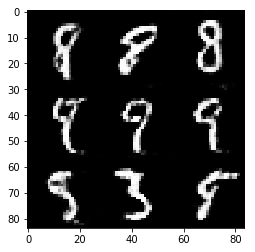

Discriminator Loss: 0.5456823110580444 
Generator Loss: 2.662571907043457


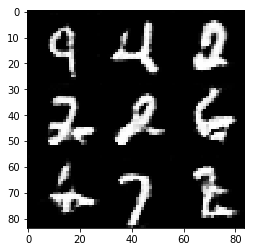

Discriminator Loss: 1.234982967376709 
Generator Loss: 4.2198028564453125


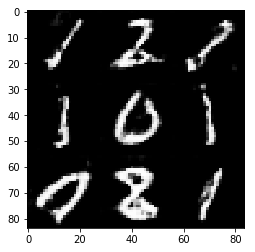

Discriminator Loss: 0.6231979131698608 
Generator Loss: 4.262040138244629


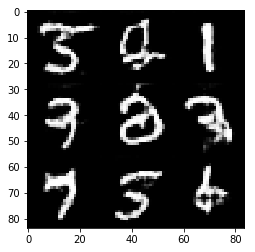

Discriminator Loss: 1.0571956634521484 
Generator Loss: 2.467238426208496


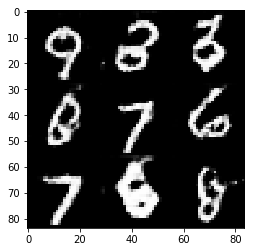

Discriminator Loss: 2.970146417617798 
Generator Loss: 5.415546894073486


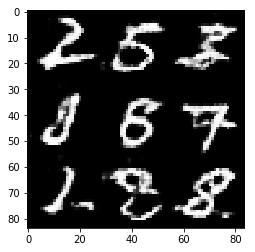

Discriminator Loss: 0.49171385169029236 
Generator Loss: 2.639852523803711


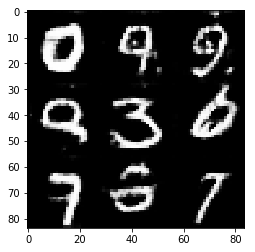

Discriminator Loss: 0.5890722870826721 
Generator Loss: 3.010134696960449


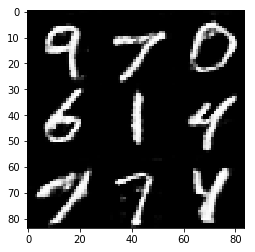

Discriminator Loss: 0.6652112603187561 
Generator Loss: 3.7375431060791016


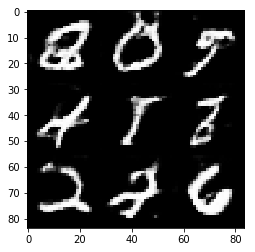

Discriminator Loss: 0.13985028862953186 
Generator Loss: 3.6487436294555664


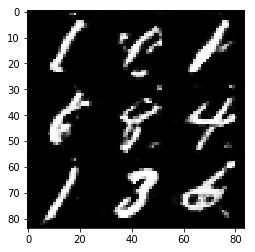

Discriminator Loss: 0.5452991127967834 
Generator Loss: 3.6853034496307373


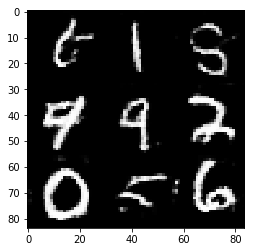

Discriminator Loss: 1.0351338386535645 
Generator Loss: 3.4827747344970703


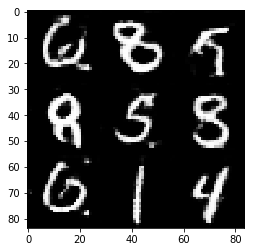

Discriminator Loss: 0.3562939167022705 
Generator Loss: 3.3128600120544434


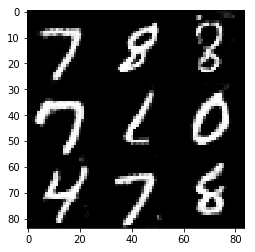

Discriminator Loss: 0.4632929861545563 
Generator Loss: 2.6433324813842773


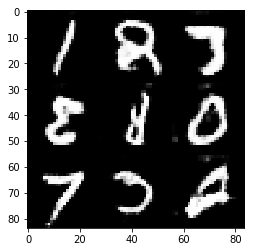

Discriminator Loss: 1.2119208574295044 
Generator Loss: 2.965240955352783


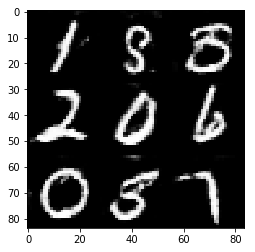

Discriminator Loss: 0.7133916020393372 
Generator Loss: 1.4930751323699951


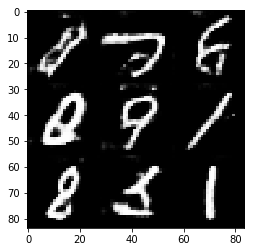

After Epoch 1
Discriminator Loss: 0.5061292052268982 
Generator Loss: 3.4533045291900635


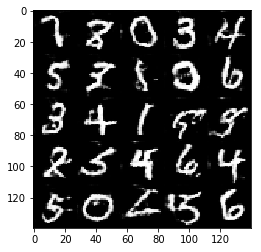

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Discriminator Loss: 1.6434311866760254 
Generator Loss: 6.122147083282471


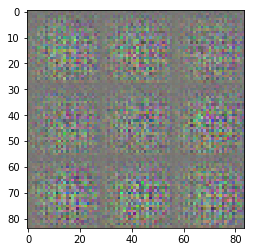

Discriminator Loss: 1.1701453924179077 
Generator Loss: 11.804994583129883


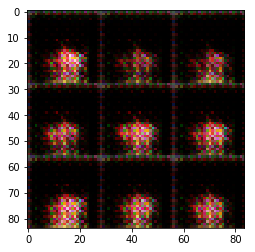

Discriminator Loss: 0.26469990611076355 
Generator Loss: 3.815528392791748


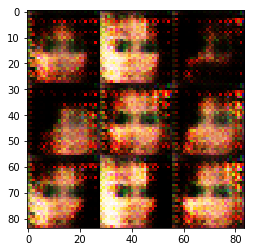

Discriminator Loss: 0.9722762107849121 
Generator Loss: 2.6302764415740967


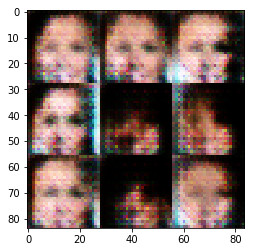

Discriminator Loss: 0.8413764238357544 
Generator Loss: 3.560234308242798


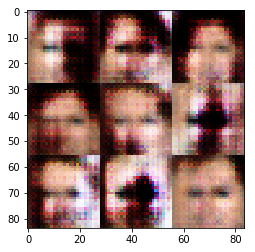

Discriminator Loss: 0.7264343500137329 
Generator Loss: 2.1935768127441406


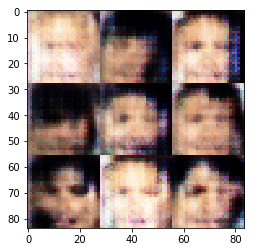

Discriminator Loss: 0.8321857452392578 
Generator Loss: 3.2855451107025146


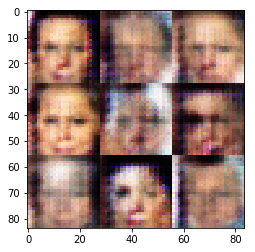

Discriminator Loss: 1.1579407453536987 
Generator Loss: 1.9458703994750977


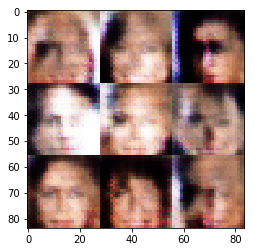

Discriminator Loss: 0.8646494746208191 
Generator Loss: 2.3729584217071533


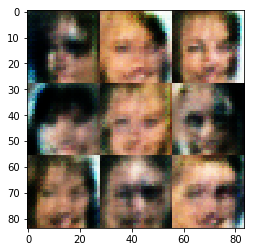

Discriminator Loss: 0.9399071335792542 
Generator Loss: 2.434894323348999


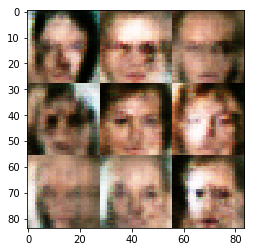

Discriminator Loss: 0.7031254768371582 
Generator Loss: 2.141775131225586


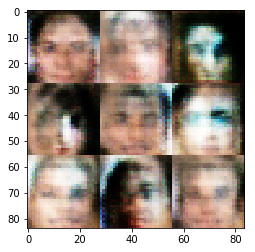

Discriminator Loss: 0.526497483253479 
Generator Loss: 3.1633360385894775


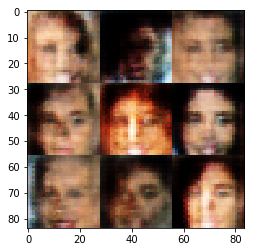

Discriminator Loss: 0.6048728823661804 
Generator Loss: 2.77846622467041


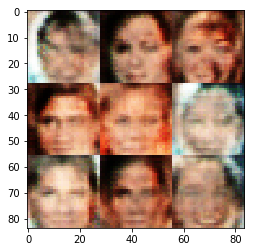

Discriminator Loss: 1.2889527082443237 
Generator Loss: 2.1722049713134766


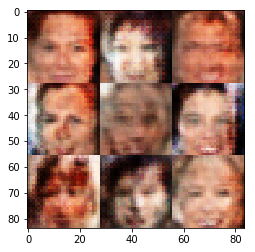

Discriminator Loss: 1.0270252227783203 
Generator Loss: 2.0644373893737793


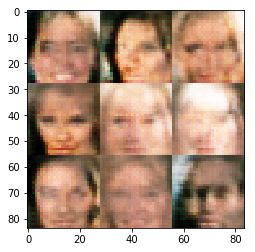

Discriminator Loss: 0.6464279890060425 
Generator Loss: 2.5248665809631348


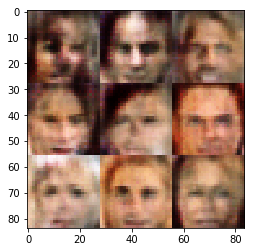

Discriminator Loss: 0.8540799617767334 
Generator Loss: 2.3566501140594482


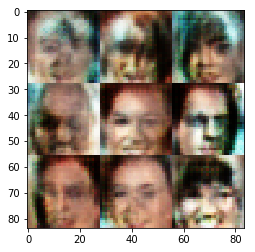

Discriminator Loss: 0.6778715252876282 
Generator Loss: 2.6548993587493896


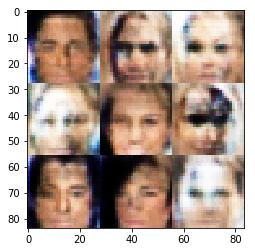

Discriminator Loss: 0.9714078903198242 
Generator Loss: 1.9622373580932617


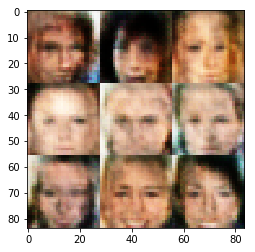

Discriminator Loss: 0.7419096231460571 
Generator Loss: 2.6212964057922363


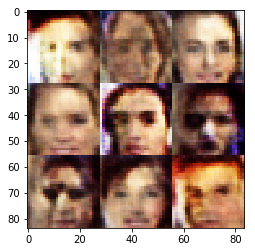

Discriminator Loss: 1.0967519283294678 
Generator Loss: 3.690162181854248


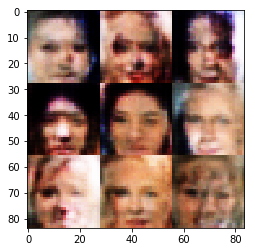

Discriminator Loss: 0.8589717149734497 
Generator Loss: 2.7690587043762207


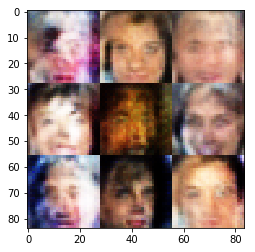

Discriminator Loss: 0.7107346653938293 
Generator Loss: 2.4736690521240234


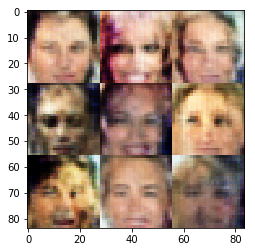

Discriminator Loss: 1.082140326499939 
Generator Loss: 1.9106640815734863


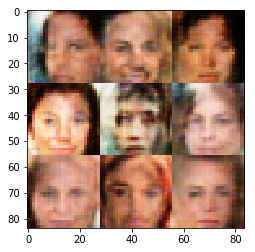

Discriminator Loss: 1.0814757347106934 
Generator Loss: 1.68815016746521


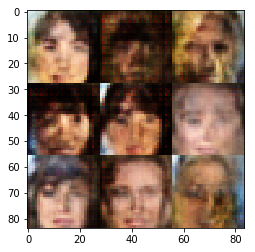

Discriminator Loss: 0.8432741165161133 
Generator Loss: 3.6138298511505127


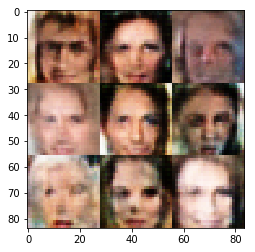

Discriminator Loss: 0.7860334515571594 
Generator Loss: 1.8773964643478394


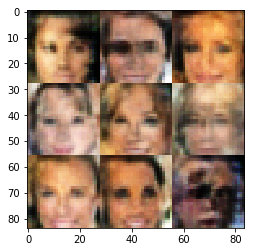

Discriminator Loss: 1.108715295791626 
Generator Loss: 1.652845025062561


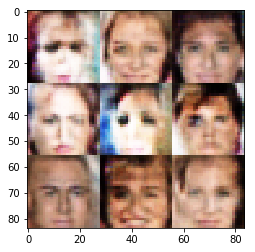

Discriminator Loss: 0.9696471095085144 
Generator Loss: 2.092715263366699


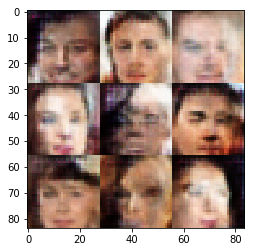

Discriminator Loss: 0.910689651966095 
Generator Loss: 1.721623420715332


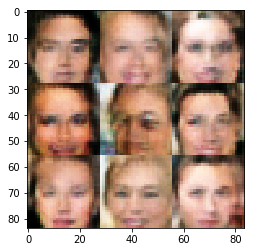

Discriminator Loss: 1.3373239040374756 
Generator Loss: 2.9808590412139893


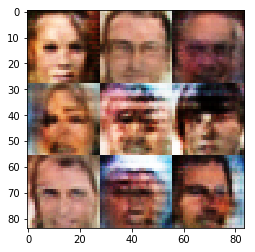

Discriminator Loss: 1.027694821357727 
Generator Loss: 1.872650384902954


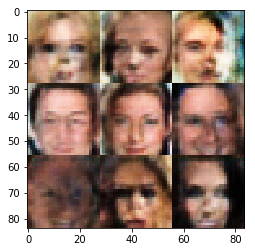

Discriminator Loss: 0.7635786533355713 
Generator Loss: 2.705744981765747


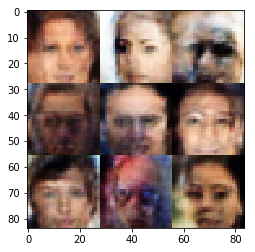

Discriminator Loss: 0.49869340658187866 
Generator Loss: 2.8663601875305176


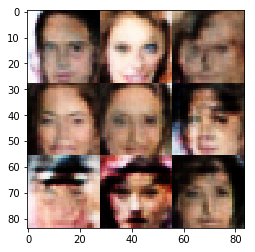

Discriminator Loss: 1.1791664361953735 
Generator Loss: 2.2257654666900635


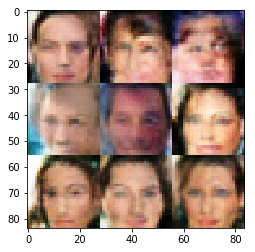

Discriminator Loss: 1.1046303510665894 
Generator Loss: 2.3271102905273438


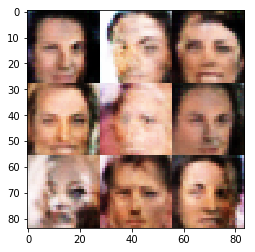

Discriminator Loss: 1.293778419494629 
Generator Loss: 2.542994737625122


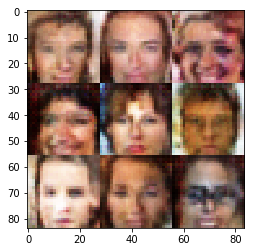

Discriminator Loss: 1.586503267288208 
Generator Loss: 2.57871675491333


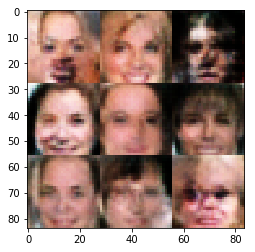

Discriminator Loss: 1.129046082496643 
Generator Loss: 2.416576385498047


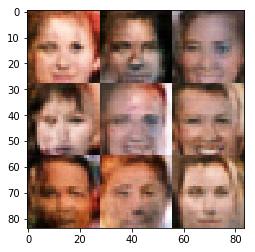

Discriminator Loss: 0.9365947842597961 
Generator Loss: 3.832836151123047


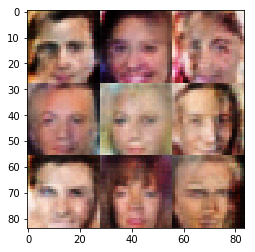

Discriminator Loss: 1.02798593044281 
Generator Loss: 3.531961679458618


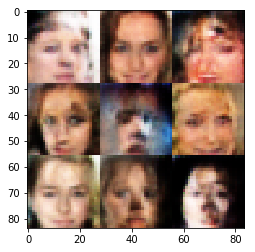

Discriminator Loss: 1.1005603075027466 
Generator Loss: 3.6544551849365234


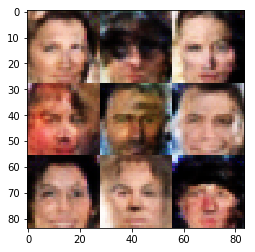

Discriminator Loss: 1.3065179586410522 
Generator Loss: 1.958404302597046


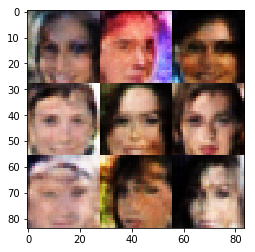

Discriminator Loss: 0.8146675825119019 
Generator Loss: 2.0236260890960693


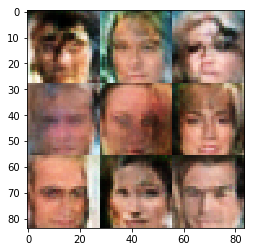

Discriminator Loss: 0.5411050319671631 
Generator Loss: 2.9948253631591797


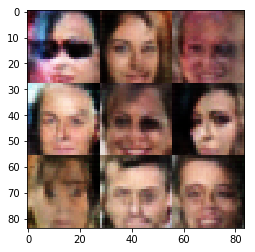

Discriminator Loss: 1.2351099252700806 
Generator Loss: 1.2371101379394531


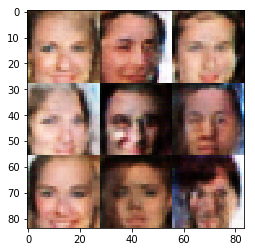

Discriminator Loss: 1.0972322225570679 
Generator Loss: 2.496858596801758


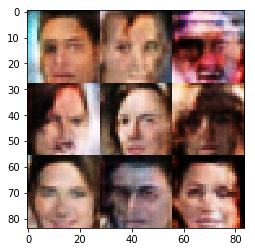

Discriminator Loss: 1.455091953277588 
Generator Loss: 1.0767911672592163


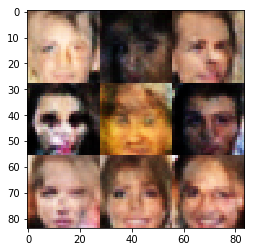

Discriminator Loss: 1.0279372930526733 
Generator Loss: 1.3914093971252441


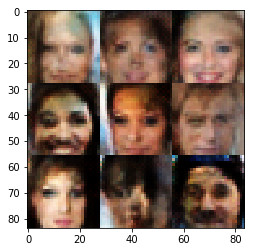

Discriminator Loss: 0.5886231064796448 
Generator Loss: 3.340299606323242


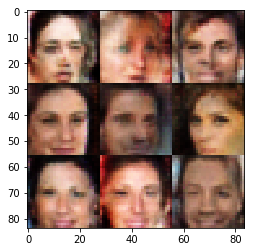

Discriminator Loss: 0.8156723380088806 
Generator Loss: 3.4716224670410156


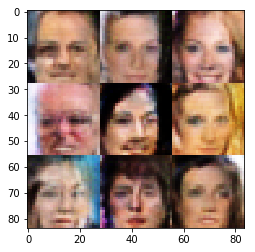

Discriminator Loss: 0.9994781017303467 
Generator Loss: 2.894580841064453


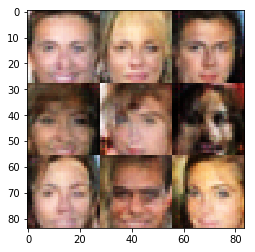

Discriminator Loss: 0.9484305381774902 
Generator Loss: 3.9180684089660645


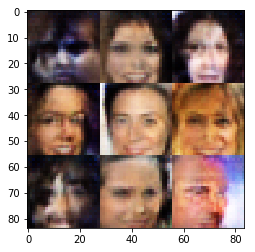

Discriminator Loss: 1.0989338159561157 
Generator Loss: 1.6885427236557007


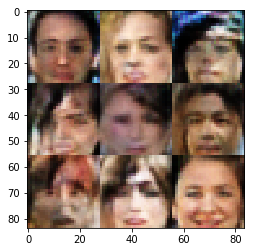

Discriminator Loss: 0.7319281101226807 
Generator Loss: 2.4717535972595215


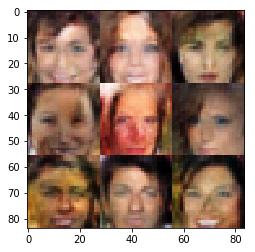

Discriminator Loss: 0.8949429988861084 
Generator Loss: 2.5951104164123535


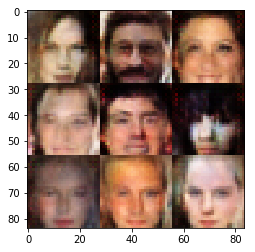

Discriminator Loss: 1.218970775604248 
Generator Loss: 1.119331955909729


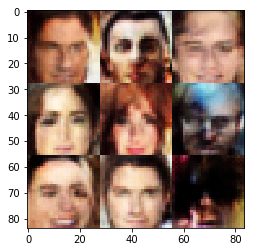

Discriminator Loss: 0.42024508118629456 
Generator Loss: 2.5072903633117676


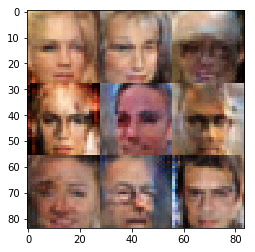

Discriminator Loss: 0.9309787154197693 
Generator Loss: 2.379075765609741


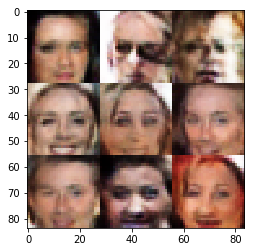

Discriminator Loss: 0.7889437675476074 
Generator Loss: 3.011327028274536


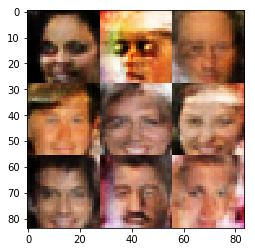

Discriminator Loss: 0.9609735012054443 
Generator Loss: 1.5148365497589111


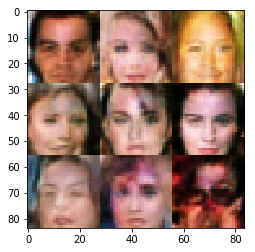

Discriminator Loss: 0.924995481967926 
Generator Loss: 1.7322828769683838


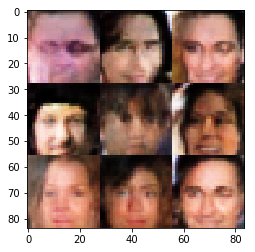

Discriminator Loss: 1.1669070720672607 
Generator Loss: 3.811634063720703


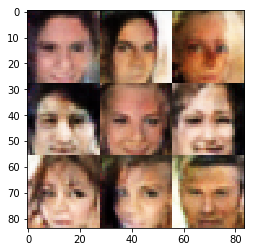

Discriminator Loss: 0.9182544946670532 
Generator Loss: 2.044823169708252


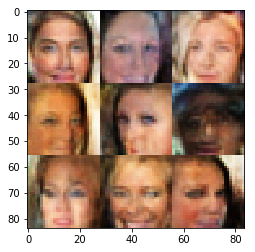

After Epoch 0
Discriminator Loss: 1.0473278760910034 
Generator Loss: 4.550793647766113


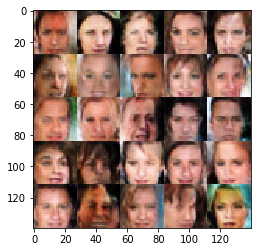

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.